In [ ]:
# Instaling in Google Colab the libraries used for this assignemnt
# Don't run this cell if you are running the notebook locally

# !pip install pygame

In [2]:
# Importing the libraries

import os
import gymnasium as gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Configuring Pytorch

# Solution of Lab Assignment 3 :  
See pdf for instructions


## Part 1: Introduction to Gym environments

### Question 1: Creating the Cartpole environment and performing an episode

In [7]:
# Creating the environment and a recorder to save a video in the './random_episode' folder
# To save multiple videos, save each mp4 fle to a new directory

cwd = os.getcwd()
video_dir = os.path.join(cwd, 'random_episode')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "random_episode.mp4")
env = gym.make('CartPole-v0', render_mode="rgb_array")

# Perform an episode in the environemnt with random actions
state = env.reset()

video_recorder = VideoRecorder(env, video_file, enabled=True)  #record a video of the episode
done = False
while not done:

    video_recorder.capture_frame()
    action = env.action_space.sample()  # sample a random possible action from the CartPole env
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

print(f"Video saved in folder {video_dir}")
env.close()

Exception ignored in: <function VideoRecorder.__del__ at 0x7fac48ac7a60>
Traceback (most recent call last):
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/gym/wrappers/monitoring/video_recorder.py", line 178, in __del__
    self.close()
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/gym/wrappers/monitoring/video_recorder.py", line 158, in close
    clip.write_videofile(self.path)
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/decorator.py", line 231, in fun
    es = ''
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/moviepy/decorators.py", line 54, in requires_duration
    return f(clip, *a, **k)
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/decorator.py", line 231, in fun
    es = ''
  File "/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/moviepy/decorators.py", line 135, in use_clip_fps_by_default
    return f(clip, *new_a, **new_kw)
  File "/Users/ruihongyu/opt/anaconda3/li

Moviepy - Building video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4.
Moviepy - Writing video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4

Moviepy - Building video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4.
Moviepy - Writing video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4



TypeError: must be real number, not NoneType

: 

### Question 2: Implementing a simple hand-designed policy

In [ ]:
# [Action required]
def simple_policy(state, p_random):
    """
    Simple hand-crafted policy to act in the Cartpole environment.
    Input:
        - state {tensor} - current state of the environment
        - p_random {float} - probability that the action is random
    Output: action {int} - action to perform in the environemnt
    """
    ####
    # Add your code here
    ####

    return 0

In [ ]:
# Rate of random action sampling
p_random = 0.2

# Performing an episode in the environemnt with simple policy
state = env.reset()
done = False
while not done:
    action = simple_policy(state, p_random)
    next_state, reward, done, info = env.step(action)
    state = next_state
env.close()

## Part 2: Introduction to PyTorch

### Helper Functions

In [ ]:
# Graphical class: this class modifies the original Gym class to be able to visualise your prediction
# You DO NOT need to understand it to work on this lab assessment

from gym.envs.classic_control.cartpole import CartPoleEnv
from gym.wrappers.time_limit import TimeLimit

class ShowCartPolePredictions(CartPoleEnv):
    def __init__(self):
        super().__init__()

    def step(self, state):
        """
        Step takes the next state as input instead of action.
        """
        self.state = state
        x, x_dot, theta, theta_dot = state

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
                )

        reward = 1.

        return np.array(self.state, dtype=np.float32), reward, done, {}

nb_path = os.path.join(os.getcwd(), 'tutorial_3_solution.ipynb')
gym.envs.register(
     id='ShowPredictionsCartPole',
     entry_point=ShowCartPolePredictions,
     max_episode_steps=500,
)

### Question 3: Understanding the MLP class

In [ ]:
# Multi Layer perceptron class

class MLP(nn.Module):

    def __init__(self, input_size, output_size, num_hidden, hidden_size):
        """
        Initialise the network.
        Input:
            - input_size {int} - size of input to the network
            - output_size {int} - size of output to the network
            - num_hidden {int} - number of hidden layers
            - hidden_size {int} - size of each hidden layer
        """
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) # First tranformation from the network input to the input of first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)]) # All the hidden transformation
        self.output_layer = nn.Linear(hidden_size, output_size) # Last tranformation from the last hidden layer output to the network output

    def forward(self, x):
        """
        Get the output of the MLP.
        Input: x {tensor} - one element or a batch of element
        Ouput: y {tensor} - corresponding output
        """
        x.to(device)
        x = self.input_layer(x) # Passing through the input layer
        x = F.relu(x) # Applying Relu activation
        for layer in self.hidden_layers:
          x = layer(x) # Passing through each hidden layer
          x = F.relu(x) # Applying Relu activation
        x = self.output_layer(x) # Passing through the output layer
        return x

In [ ]:
# Initialise an MLP instance
input_size = 10
output_size = 10
num_hidden = 3
hidden_size = 15

model = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating some false input
x = torch.rand(10) # Random tensor
print("The input is:\n", x)

# Passing it through the network
y = model.forward(x)
print("\nThe correpsonding output is:\n", y)
print("\nThe network has not been trained yet so this output is random.")

The input is:
 tensor([0.0743, 0.7883, 0.0474, 0.7741, 0.5591, 0.3715, 0.8818, 0.3100, 0.1044,
        0.0415])

The correpsonding output is:
 tensor([ 0.0092,  0.2972, -0.2255, -0.1776, -0.2508,  0.1617,  0.1625, -0.0214,
         0.0931,  0.2808], grad_fn=<AddBackward0>)

The network has not been trained yet so this output is random.


### Question 4: Collecting data to train the state-predictor model

In [ ]:
def batch_data(state_list, action_list, next_state_list, batch_size, num_batches):
  """
  Reshape the data to match the model requirements.
  Input:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
    - batch_size {int} - number of steps in a batch
    - num_batches {int} - total number of batches
  Ouput:
    - batched_state_action {torch.tensor} - input of the model of size (batch_size, 5)
    - batched_next_state {torch.tensor} - target output of the model of size (batch_size, 4)
  """
  # Reshape and concatenate the state and action (input of the network)
  state_action_list = [torch.cat((torch.tensor(state_list[i]).float().unsqueeze(0), torch.tensor(action_list[i]).unsqueeze(0).unsqueeze(0)), dim=-1) for i in range(len(state_list))]
  state_action = torch.cat(state_action_list)

  # Reshape the next state
  next_state = torch.cat([torch.tensor(next_state_list[i]).float().unsqueeze(0) for i in range(len(next_state_list))])

  # Rearrange the data into batches
  batched_state_action = [state_action[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]
  batched_next_state = [next_state[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]

  return batched_state_action, batched_next_state

In [ ]:
# [Action required]
def collect_data(num_episodes, p_random):
  """
  Collect the data to train the predictor model.
  Input:
    - num_episode {int} - number of episodes to collect
    - p_random {float} - probability used for the simple policy
  Output:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
  """

  # Containers for the data
  state_list = [] # List of current states
  action_list = [] # List of current actions
  next_state_list = [] # List of next step states

  # Creating the environment
  env = gym.make('CartPole-v0')

  ####
  # Add your code here
  # This is an example on how to fill state_list, action_list and next_state_list
  # You would need to update it to collect enough data

  state = env.reset()
  action = simple_policy(state, p_random)
  next_state, reward, done, _ = env.step(action)
  state_list.append(state)
  action_list.append(action)
  next_state_list.append(next_state)

  ####


  # Closing the environment
  env.close()

  return state_list, action_list, next_state_list

In [ ]:
# Define parameters for the model
num_episodes = 5000 # Total number of episodes collected in our dataset
batch_size = 128 # Size of the batch to train the DNN
p_random = 0.2 # Parameter of the simple_policy

# Collect the data
state_list, action_list, next_state_list = collect_data(num_episodes, p_random)
num_batches = int(len(state_list)/batch_size)

# Reshape them to match the model input/output
batched_state_action, batched_next_state = batch_data(state_list, action_list, next_state_list, batch_size, num_batches)

### Question 5: Training a state predictor model

In [ ]:
def MSE_loss(prediction, target):
  """
  MSE loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - MSE error between the prediction and the target
  """
  return ((prediction - target)**2).sum(dim=-1).mean()

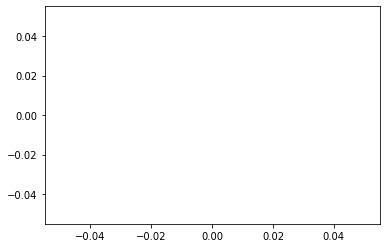

In [ ]:
# Creating the environment
env = gym.make('CartPole-v0')

# Defining the parameters
state_dim = 4
action_dim = 1

input_size = state_dim + action_dim
output_size = state_dim
num_hidden = 2
hidden_size = 50

# Creating the predictor model
state_predictor = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating the optmizer
optimiser = optim.Adam(state_predictor.parameters())

# [Action required]
# Training loop
num_epochs = 5
losses = [] # Contain all successive loss function values

####
# Add your code here
####

# Closing the environment
env.close()

# Plot the loss across training
plt.plot(losses)

In [ ]:
# Displaying the learned model dynamics in the CartPole environment

# simulated_env allows us to visualise the learned model dynamics
# by calling simulated_env.set_next_state(next_state) we set the learned
# next_state and we can visualise what the learned dynamics looks like
# video saved in the 'learned_dynamics' folder

# setting up the visualisation

cwd = os.getcwd()
video_dir = os.path.join(cwd, 'learned_dynamics')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "learned_dynamics.mp4")

simulated_env = gym.make('ShowPredictionsCartPole')
#TimeLimit)(ShowCartPolePredictions(), max_episode_steps=500)
video_recorder = VideoRecorder(simulated_env, video_file, enabled=True)

state = simulated_env.reset()

#Performing the episode
state = simulated_env.reset()
done = False
state = torch.tensor(simulated_env.state).float()

while not done:

    # Store the current state of the CartPole for the video
    video_recorder.capture_frame()

    # Predict the state with the model
    action = torch.tensor([simple_policy(state, p_random)])
    state_action = torch.cat((state, action))
    with torch.no_grad():
        predicted_state = state_predictor(state_action)
        predicted_state = list([float(s) for s in predicted_state.squeeze()])

    # Apply it in the environment
    state, reward, done, info = simulated_env.step(predicted_state)
    state = torch.tensor(simulated_env.state).float()

video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

simulated_env.close()

### Question 6: Trying multiple loss functions

In [ ]:
# Alternative loss function

def L1_loss(prediction, target):
  """
  L1 loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - L1 error between the prediction and the target
  """
  return (abs(prediction - target)).sum()

In [ ]:
## Torch MSE loss function
torch_MSE_loss = nn.MSELoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_MSE_loss(state_predictor(inputs), targets)
print(loss)

## Torch L1 loss function
torch_L1_loss = nn.L1Loss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_L1_loss(state_predictor(inputs), targets)
print(loss)

## Torch Huber loss function
torch_Huber_loss = nn.HuberLoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_Huber_loss(state_predictor(inputs), targets)
print(loss)

IndexError: ignored